<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting%20%7C%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

In [2]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/Datasets/final_dataset_fs_db.csv', parse_dates=['dates'],  index_col='dates',infer_datetime_format=True)
df.drop(['Unnamed: 0', 'Purity'], axis=1, inplace=True)

In [3]:
import tensorflow as tf

from matplotlib.pyplot import figure
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [5]:
# Normalization
values = df[['% Silica Concentrate']].values

# Normalization
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(values)

In [4]:
def create_data(series, prev_instances = 4):
 
    X_train_1 = pd.DataFrame(series).astype('float64')
    X_train_temp = X_train_1.shift(1)
    y_label = X_train_1.shift(-1)
    
    data = pd.concat([X_train_temp, X_train_1, y_label], axis=1)
    
    for r in range(prev_instances-2):
      X_train_temp = X_train_temp.shift(1)
      data = pd.concat([X_train_temp, data], axis=1)
    data.dropna(inplace = True)
    data.reset_index(drop = True, inplace = True)
    # print(data.head(10))
    X = data.iloc[:, 0:-1].values 
    y = data.iloc[:,-1].values 
    
    print('This series takes {} previous instances'.format(prev_instances))
    
    data.columns = [*data.columns[:-1], 'y']
    
    return data, X, y

In [6]:
WINDOW_SIZE = 5

time_series = scaled_data;
data, X, y = create_data(time_series, prev_instances = WINDOW_SIZE)

This series takes 5 previous instances


In [7]:
# 70% 15% 15%

X_train, y_train = X[:3935], y[:3935]
X_test, y_test = X[3935:4775], y[3935:4775]
X_val, y_val = X[4775:], y[4775:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((3935, 5), (3935,), (840, 5), (840,), (841, 5), (841,))

You always have to give a three-dimensional array as an input to your LSTM network. Where the first dimension represents the batch size, the second dimension represents the number of time-steps you are feeding a sequence. And the third dimension represents the number of units in one input sequence. For example, input shape looks like (batch_size, time_steps, seq_len)

In [8]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], WINDOW_SIZE,1))
X_test = X_test.reshape((X_test.shape[0], WINDOW_SIZE, 1))
X_val = X_val.reshape((X_val.shape[0], WINDOW_SIZE, 1))
    
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((3935, 5, 1), (3935,), (840, 5, 1), (840,), (841, 5, 1), (841,))

In [9]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
sweep_lstm_config = {
    "method": "random", # try grid or random
    "metric": {
      "name": "MAPE",
      "goal": "minimize"   
    },
    "parameters": {
          "learning_rate": {
            "values": [0.001, 0.025, 0.01]
        },
        "epochs": {
            "values": [100, 200, 300]
        },
        
        "batch_size": {
            "values": [32, 64, 128]
        }
    }
}

sweep_id = wandb.sweep(sweep_lstm_config, project="Stacked_lstm_shot_2")

Create sweep with ID: yhjuxdf0
Sweep URL: https://wandb.ai/malekkamoua/Stacked_lstm_shot_2/sweeps/yhjuxdf0


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer

from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError, MeanAbsolutePercentageError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Define early_stopping_monitor
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

from wandb.keras import WandbCallback

def train():
  config_defaults = {
    "learning_rate": 0.001,
    "epochs": 100,
    "batch_size": 32,
    'shuffle': False
  }

  wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
  config = wandb.config

  cp = ModelCheckpoint('model/', save_best_only=True)

  #define the model
  model=Sequential()
  model.add(LSTM(100,return_sequences=True,input_shape=(X_train.shape[1],1)))
  model.add(LSTM(100,return_sequences=True))
  model.add(LSTM(100,return_sequences=True))
  model.add(Dense(50, activation='relu'))
  model.add(LSTM(50,return_sequences=True))
  model.add(LSTM(50))
  model.add(Dense(1))
  
  model.compile( loss = MeanSquaredError(), 
                    optimizer = Adam(learning_rate= wandb.config['learning_rate']), 
                    metrics=['mae',
                          MeanSquaredError(),
                          RootMeanSquaredError(),
                          MeanAbsolutePercentageError()])

  history = model.fit(X_train, y_train, 
                      epochs = wandb.config['epochs'] , 
                      batch_size = wandb.config['batch_size'],
                      shuffle = wandb.config['shuffle'],
                      validation_data=(X_test, y_test),
                      callbacks= [early_stopping_monitor, 
                                  WandbCallback()])  
  
  y_pred_test_LSTM = model.predict(np.asarray(X_test).astype('float32'))
  Inverse_y_test = y_test.reshape(-1,1)
  Inverse_y_test = scaler.inverse_transform(Inverse_y_test)
  Inverse_y_pred_test_LSTM = y_pred_test_LSTM.reshape(-1,1)
  Inverse_y_pred_test_LSTM = scaler.inverse_transform(Inverse_y_pred_test_LSTM)

  mape, mae, rmse = forecast_accuracy(Inverse_y_pred_test_LSTM, Inverse_y_test)

  wandb.log({"MAPE": mape})

  wandb.finish()

In [ ]:
wandb.agent(sweep_id, train, count=40)

In [10]:
import time

from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer

from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError, MeanAbsolutePercentageError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Define early_stopping_monitor
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

cp = ModelCheckpoint('model/', save_best_only=True)

#define the model
model=Sequential()
model.add(LSTM(100,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100,return_sequences=True))
model.add(Dense(50, activation='relu'))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile( loss = MeanSquaredError(), 
                  optimizer = Adam(learning_rate= 0.001), 
                  metrics=['mae',
                        MeanSquaredError(),
                        RootMeanSquaredError(),
                        MeanAbsolutePercentageError()])

start = time.time()
print(start)
history_LSTM = model.fit(X_train, y_train, 
                              epochs = 300 , 
                              batch_size = 128,
                              shuffle =False,
                              validation_data=(X_test, y_test),
                              callbacks= [cp,
                                          early_stopping_monitor])   

stop = time.time()
print(stop)

1652178344.369096
Epoch 1/300
31/31 [==============================] - ETA: 0s - loss: 0.1241 - mae: 0.2826 - mean_squared_error: 0.1244 - root_mean_squared_error: 0.3522 - mean_absolute_percentage_error: 81.2362

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 50s 1s/step - loss: 0.1241 - mae: 0.2826 - mean_squared_error: 0.1244 - root_mean_squared_error: 0.3522 - mean_absolute_percentage_error: 81.2362 - val_loss: 0.0636 - val_mae: 0.1788 - val_mean_squared_error: 0.0632 - val_root_mean_squared_error: 0.2522 - val_mean_absolute_percentage_error: 48.1604
Epoch 2/300
30/31 [============================>.] - ETA: 0s - loss: 0.0816 - mae: 0.2409 - mean_squared_error: 0.0816 - root_mean_squared_error: 0.2856 - mean_absolute_percentage_error: 86.9628

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 23s 777ms/step - loss: 0.0828 - mae: 0.2422 - mean_squared_error: 0.0832 - root_mean_squared_error: 0.2877 - mean_absolute_percentage_error: 86.4103 - val_loss: 0.0504 - val_mae: 0.1706 - val_mean_squared_error: 0.0495 - val_root_mean_squared_error: 0.2245 - val_mean_absolute_percentage_error: 56.8441
Epoch 3/300
30/31 [============================>.] - ETA: 0s - loss: 0.0690 - mae: 0.2235 - mean_squared_error: 0.0690 - root_mean_squared_error: 0.2626 - mean_absolute_percentage_error: 80.2974

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 794ms/step - loss: 0.0698 - mae: 0.2246 - mean_squared_error: 0.0701 - root_mean_squared_error: 0.2642 - mean_absolute_percentage_error: 79.9784 - val_loss: 0.0423 - val_mae: 0.1599 - val_mean_squared_error: 0.0414 - val_root_mean_squared_error: 0.2056 - val_mean_absolute_percentage_error: 56.1232
Epoch 4/300
30/31 [============================>.] - ETA: 0s - loss: 0.0462 - mae: 0.1753 - mean_squared_error: 0.0462 - root_mean_squared_error: 0.2149 - mean_absolute_percentage_error: 61.0124

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 783ms/step - loss: 0.0472 - mae: 0.1770 - mean_squared_error: 0.0476 - root_mean_squared_error: 0.2173 - mean_absolute_percentage_error: 61.0446 - val_loss: 0.0379 - val_mae: 0.1469 - val_mean_squared_error: 0.0372 - val_root_mean_squared_error: 0.1948 - val_mean_absolute_percentage_error: 48.3957
Epoch 5/300
31/31 [==============================] - ETA: 0s - loss: 0.0386 - mae: 0.1520 - mean_squared_error: 0.0390 - root_mean_squared_error: 0.1966 - mean_absolute_percentage_error: 53.1613

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 25s 841ms/step - loss: 0.0386 - mae: 0.1520 - mean_squared_error: 0.0390 - root_mean_squared_error: 0.1966 - mean_absolute_percentage_error: 53.1613 - val_loss: 0.0334 - val_mae: 0.1383 - val_mean_squared_error: 0.0325 - val_root_mean_squared_error: 0.1827 - val_mean_absolute_percentage_error: 48.0694
Epoch 6/300
30/31 [============================>.] - ETA: 0s - loss: 0.0349 - mae: 0.1419 - mean_squared_error: 0.0349 - root_mean_squared_error: 0.1868 - mean_absolute_percentage_error: 50.8380

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 783ms/step - loss: 0.0357 - mae: 0.1435 - mean_squared_error: 0.0360 - root_mean_squared_error: 0.1890 - mean_absolute_percentage_error: 51.2034 - val_loss: 0.0318 - val_mae: 0.1331 - val_mean_squared_error: 0.0309 - val_root_mean_squared_error: 0.1784 - val_mean_absolute_percentage_error: 46.9624
Epoch 7/300
31/31 [==============================] - ETA: 0s - loss: 0.0348 - mae: 0.1405 - mean_squared_error: 0.0351 - root_mean_squared_error: 0.1867 - mean_absolute_percentage_error: 50.1986

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 786ms/step - loss: 0.0348 - mae: 0.1405 - mean_squared_error: 0.0351 - root_mean_squared_error: 0.1867 - mean_absolute_percentage_error: 50.1986 - val_loss: 0.0313 - val_mae: 0.1316 - val_mean_squared_error: 0.0304 - val_root_mean_squared_error: 0.1770 - val_mean_absolute_percentage_error: 46.7533
Epoch 8/300
30/31 [============================>.] - ETA: 0s - loss: 0.0337 - mae: 0.1379 - mean_squared_error: 0.0337 - root_mean_squared_error: 0.1837 - mean_absolute_percentage_error: 49.3797

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 23s 767ms/step - loss: 0.0345 - mae: 0.1393 - mean_squared_error: 0.0347 - root_mean_squared_error: 0.1856 - mean_absolute_percentage_error: 49.7688 - val_loss: 0.0309 - val_mae: 0.1304 - val_mean_squared_error: 0.0300 - val_root_mean_squared_error: 0.1758 - val_mean_absolute_percentage_error: 46.3278
Epoch 9/300
30/31 [============================>.] - ETA: 0s - loss: 0.0335 - mae: 0.1374 - mean_squared_error: 0.0335 - root_mean_squared_error: 0.1829 - mean_absolute_percentage_error: 49.2501

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 23s 781ms/step - loss: 0.0341 - mae: 0.1388 - mean_squared_error: 0.0344 - root_mean_squared_error: 0.1848 - mean_absolute_percentage_error: 49.6276 - val_loss: 0.0306 - val_mae: 0.1294 - val_mean_squared_error: 0.0297 - val_root_mean_squared_error: 0.1748 - val_mean_absolute_percentage_error: 45.9667
Epoch 10/300
30/31 [============================>.] - ETA: 0s - loss: 0.0332 - mae: 0.1369 - mean_squared_error: 0.0332 - root_mean_squared_error: 0.1822 - mean_absolute_percentage_error: 48.9920

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 801ms/step - loss: 0.0339 - mae: 0.1382 - mean_squared_error: 0.0341 - root_mean_squared_error: 0.1840 - mean_absolute_percentage_error: 49.3577 - val_loss: 0.0302 - val_mae: 0.1284 - val_mean_squared_error: 0.0293 - val_root_mean_squared_error: 0.1738 - val_mean_absolute_percentage_error: 45.4924
Epoch 11/300
30/31 [============================>.] - ETA: 0s - loss: 0.0329 - mae: 0.1364 - mean_squared_error: 0.0329 - root_mean_squared_error: 0.1815 - mean_absolute_percentage_error: 48.8223

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 796ms/step - loss: 0.0336 - mae: 0.1376 - mean_squared_error: 0.0338 - root_mean_squared_error: 0.1832 - mean_absolute_percentage_error: 49.1768 - val_loss: 0.0299 - val_mae: 0.1278 - val_mean_squared_error: 0.0290 - val_root_mean_squared_error: 0.1729 - val_mean_absolute_percentage_error: 45.2372
Epoch 12/300
30/31 [============================>.] - ETA: 0s - loss: 0.0326 - mae: 0.1357 - mean_squared_error: 0.0326 - root_mean_squared_error: 0.1807 - mean_absolute_percentage_error: 48.5502

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 794ms/step - loss: 0.0333 - mae: 0.1369 - mean_squared_error: 0.0335 - root_mean_squared_error: 0.1824 - mean_absolute_percentage_error: 48.8947 - val_loss: 0.0295 - val_mae: 0.1270 - val_mean_squared_error: 0.0287 - val_root_mean_squared_error: 0.1719 - val_mean_absolute_percentage_error: 44.9235
Epoch 13/300
31/31 [==============================] - ETA: 0s - loss: 0.0329 - mae: 0.1359 - mean_squared_error: 0.0331 - root_mean_squared_error: 0.1813 - mean_absolute_percentage_error: 48.4501

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 23s 777ms/step - loss: 0.0329 - mae: 0.1359 - mean_squared_error: 0.0331 - root_mean_squared_error: 0.1813 - mean_absolute_percentage_error: 48.4501 - val_loss: 0.0291 - val_mae: 0.1261 - val_mean_squared_error: 0.0283 - val_root_mean_squared_error: 0.1706 - val_mean_absolute_percentage_error: 44.5267
Epoch 14/300
30/31 [============================>.] - ETA: 0s - loss: 0.0317 - mae: 0.1331 - mean_squared_error: 0.0317 - root_mean_squared_error: 0.1781 - mean_absolute_percentage_error: 47.5489

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 805ms/step - loss: 0.0323 - mae: 0.1343 - mean_squared_error: 0.0325 - root_mean_squared_error: 0.1798 - mean_absolute_percentage_error: 47.8836 - val_loss: 0.0285 - val_mae: 0.1250 - val_mean_squared_error: 0.0277 - val_root_mean_squared_error: 0.1689 - val_mean_absolute_percentage_error: 44.3568
Epoch 15/300
30/31 [============================>.] - ETA: 0s - loss: 0.0310 - mae: 0.1305 - mean_squared_error: 0.0310 - root_mean_squared_error: 0.1759 - mean_absolute_percentage_error: 46.6198

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 782ms/step - loss: 0.0315 - mae: 0.1317 - mean_squared_error: 0.0317 - root_mean_squared_error: 0.1775 - mean_absolute_percentage_error: 46.9682 - val_loss: 0.0275 - val_mae: 0.1230 - val_mean_squared_error: 0.0266 - val_root_mean_squared_error: 0.1658 - val_mean_absolute_percentage_error: 44.5082
Epoch 16/300
31/31 [==============================] - ETA: 0s - loss: 0.0301 - mae: 0.1273 - mean_squared_error: 0.0303 - root_mean_squared_error: 0.1736 - mean_absolute_percentage_error: 45.5460

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 810ms/step - loss: 0.0301 - mae: 0.1273 - mean_squared_error: 0.0303 - root_mean_squared_error: 0.1736 - mean_absolute_percentage_error: 45.5460 - val_loss: 0.0264 - val_mae: 0.1205 - val_mean_squared_error: 0.0255 - val_root_mean_squared_error: 0.1626 - val_mean_absolute_percentage_error: 47.6226
Epoch 17/300
30/31 [============================>.] - ETA: 0s - loss: 0.0277 - mae: 0.1233 - mean_squared_error: 0.0277 - root_mean_squared_error: 0.1663 - mean_absolute_percentage_error: 44.5236

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 782ms/step - loss: 0.0281 - mae: 0.1243 - mean_squared_error: 0.0283 - root_mean_squared_error: 0.1677 - mean_absolute_percentage_error: 44.6874 - val_loss: 0.0242 - val_mae: 0.1097 - val_mean_squared_error: 0.0233 - val_root_mean_squared_error: 0.1555 - val_mean_absolute_percentage_error: 37.7420
Epoch 18/300
30/31 [============================>.] - ETA: 0s - loss: 0.0263 - mae: 0.1200 - mean_squared_error: 0.0263 - root_mean_squared_error: 0.1622 - mean_absolute_percentage_error: 41.5264

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 23s 778ms/step - loss: 0.0269 - mae: 0.1212 - mean_squared_error: 0.0271 - root_mean_squared_error: 0.1640 - mean_absolute_percentage_error: 41.5924 - val_loss: 0.0230 - val_mae: 0.1066 - val_mean_squared_error: 0.0221 - val_root_mean_squared_error: 0.1516 - val_mean_absolute_percentage_error: 34.6253
Epoch 19/300
31/31 [==============================] - ETA: 0s - loss: 0.0230 - mae: 0.1091 - mean_squared_error: 0.0230 - root_mean_squared_error: 0.1516 - mean_absolute_percentage_error: 37.9072

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 782ms/step - loss: 0.0230 - mae: 0.1091 - mean_squared_error: 0.0230 - root_mean_squared_error: 0.1516 - mean_absolute_percentage_error: 37.9072 - val_loss: 0.0195 - val_mae: 0.0930 - val_mean_squared_error: 0.0187 - val_root_mean_squared_error: 0.1397 - val_mean_absolute_percentage_error: 33.3975
Epoch 20/300
30/31 [============================>.] - ETA: 0s - loss: 0.0197 - mae: 0.0942 - mean_squared_error: 0.0197 - root_mean_squared_error: 0.1402 - mean_absolute_percentage_error: 33.8200

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 803ms/step - loss: 0.0199 - mae: 0.0941 - mean_squared_error: 0.0199 - root_mean_squared_error: 0.1409 - mean_absolute_percentage_error: 33.9894 - val_loss: 0.0184 - val_mae: 0.0915 - val_mean_squared_error: 0.0177 - val_root_mean_squared_error: 0.1358 - val_mean_absolute_percentage_error: 33.8641
Epoch 21/300
30/31 [============================>.] - ETA: 0s - loss: 0.0188 - mae: 0.0915 - mean_squared_error: 0.0188 - root_mean_squared_error: 0.1372 - mean_absolute_percentage_error: 31.9720

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 23s 778ms/step - loss: 0.0190 - mae: 0.0914 - mean_squared_error: 0.0191 - root_mean_squared_error: 0.1379 - mean_absolute_percentage_error: 32.0885 - val_loss: 0.0181 - val_mae: 0.0886 - val_mean_squared_error: 0.0174 - val_root_mean_squared_error: 0.1346 - val_mean_absolute_percentage_error: 32.4757
Epoch 22/300
31/31 [==============================] - ETA: 0s - loss: 0.0186 - mae: 0.0895 - mean_squared_error: 0.0187 - root_mean_squared_error: 0.1365 - mean_absolute_percentage_error: 31.4726

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 796ms/step - loss: 0.0186 - mae: 0.0895 - mean_squared_error: 0.0187 - root_mean_squared_error: 0.1365 - mean_absolute_percentage_error: 31.4726 - val_loss: 0.0175 - val_mae: 0.0854 - val_mean_squared_error: 0.0168 - val_root_mean_squared_error: 0.1325 - val_mean_absolute_percentage_error: 30.7637
Epoch 23/300
31/31 [==============================] - ETA: 0s - loss: 0.0183 - mae: 0.0880 - mean_squared_error: 0.0184 - root_mean_squared_error: 0.1353 - mean_absolute_percentage_error: 30.6176

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 23s 781ms/step - loss: 0.0183 - mae: 0.0880 - mean_squared_error: 0.0184 - root_mean_squared_error: 0.1353 - mean_absolute_percentage_error: 30.6176 - val_loss: 0.0173 - val_mae: 0.0835 - val_mean_squared_error: 0.0166 - val_root_mean_squared_error: 0.1314 - val_mean_absolute_percentage_error: 29.8796
Epoch 24/300
30/31 [============================>.] - ETA: 0s - loss: 0.0179 - mae: 0.0869 - mean_squared_error: 0.0179 - root_mean_squared_error: 0.1337 - mean_absolute_percentage_error: 30.0989

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 785ms/step - loss: 0.0181 - mae: 0.0868 - mean_squared_error: 0.0181 - root_mean_squared_error: 0.1344 - mean_absolute_percentage_error: 30.2159 - val_loss: 0.0170 - val_mae: 0.0816 - val_mean_squared_error: 0.0163 - val_root_mean_squared_error: 0.1304 - val_mean_absolute_percentage_error: 29.0102
Epoch 25/300
31/31 [==============================] - ETA: 0s - loss: 0.0179 - mae: 0.0857 - mean_squared_error: 0.0179 - root_mean_squared_error: 0.1337 - mean_absolute_percentage_error: 29.6362

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 789ms/step - loss: 0.0179 - mae: 0.0857 - mean_squared_error: 0.0179 - root_mean_squared_error: 0.1337 - mean_absolute_percentage_error: 29.6362 - val_loss: 0.0168 - val_mae: 0.0802 - val_mean_squared_error: 0.0162 - val_root_mean_squared_error: 0.1298 - val_mean_absolute_percentage_error: 28.4253
Epoch 26/300
30/31 [============================>.] - ETA: 0s - loss: 0.0176 - mae: 0.0853 - mean_squared_error: 0.0176 - root_mean_squared_error: 0.1325 - mean_absolute_percentage_error: 29.2954

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 28s 947ms/step - loss: 0.0177 - mae: 0.0851 - mean_squared_error: 0.0178 - root_mean_squared_error: 0.1332 - mean_absolute_percentage_error: 29.4032 - val_loss: 0.0167 - val_mae: 0.0790 - val_mean_squared_error: 0.0160 - val_root_mean_squared_error: 0.1292 - val_mean_absolute_percentage_error: 27.7955
Epoch 27/300
31/31 [==============================] - ETA: 0s - loss: 0.0176 - mae: 0.0845 - mean_squared_error: 0.0177 - root_mean_squared_error: 0.1328 - mean_absolute_percentage_error: 29.1201

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 23s 780ms/step - loss: 0.0176 - mae: 0.0845 - mean_squared_error: 0.0177 - root_mean_squared_error: 0.1328 - mean_absolute_percentage_error: 29.1201 - val_loss: 0.0166 - val_mae: 0.0782 - val_mean_squared_error: 0.0159 - val_root_mean_squared_error: 0.1287 - val_mean_absolute_percentage_error: 27.6028
Epoch 28/300
31/31 [==============================] - ETA: 0s - loss: 0.0175 - mae: 0.0838 - mean_squared_error: 0.0176 - root_mean_squared_error: 0.1325 - mean_absolute_percentage_error: 28.9008

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 802ms/step - loss: 0.0175 - mae: 0.0838 - mean_squared_error: 0.0176 - root_mean_squared_error: 0.1325 - mean_absolute_percentage_error: 28.9008 - val_loss: 0.0165 - val_mae: 0.0779 - val_mean_squared_error: 0.0158 - val_root_mean_squared_error: 0.1283 - val_mean_absolute_percentage_error: 27.6445
Epoch 29/300
30/31 [============================>.] - ETA: 0s - loss: 0.0173 - mae: 0.0835 - mean_squared_error: 0.0173 - root_mean_squared_error: 0.1315 - mean_absolute_percentage_error: 28.5455

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 782ms/step - loss: 0.0175 - mae: 0.0833 - mean_squared_error: 0.0175 - root_mean_squared_error: 0.1321 - mean_absolute_percentage_error: 28.6685 - val_loss: 0.0164 - val_mae: 0.0777 - val_mean_squared_error: 0.0157 - val_root_mean_squared_error: 0.1279 - val_mean_absolute_percentage_error: 27.7301
Epoch 30/300
30/31 [============================>.] - ETA: 0s - loss: 0.0172 - mae: 0.0829 - mean_squared_error: 0.0172 - root_mean_squared_error: 0.1312 - mean_absolute_percentage_error: 28.3001

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 23s 779ms/step - loss: 0.0174 - mae: 0.0827 - mean_squared_error: 0.0174 - root_mean_squared_error: 0.1319 - mean_absolute_percentage_error: 28.4373 - val_loss: 0.0163 - val_mae: 0.0777 - val_mean_squared_error: 0.0157 - val_root_mean_squared_error: 0.1278 - val_mean_absolute_percentage_error: 27.8862
Epoch 31/300
31/31 [==============================] - ETA: 0s - loss: 0.0173 - mae: 0.0821 - mean_squared_error: 0.0174 - root_mean_squared_error: 0.1316 - mean_absolute_percentage_error: 28.2550

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 802ms/step - loss: 0.0173 - mae: 0.0821 - mean_squared_error: 0.0174 - root_mean_squared_error: 0.1316 - mean_absolute_percentage_error: 28.2550 - val_loss: 0.0163 - val_mae: 0.0778 - val_mean_squared_error: 0.0156 - val_root_mean_squared_error: 0.1277 - val_mean_absolute_percentage_error: 28.0663
Epoch 32/300
31/31 [==============================] - ETA: 0s - loss: 0.0173 - mae: 0.0816 - mean_squared_error: 0.0173 - root_mean_squared_error: 0.1314 - mean_absolute_percentage_error: 28.0423

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 789ms/step - loss: 0.0173 - mae: 0.0816 - mean_squared_error: 0.0173 - root_mean_squared_error: 0.1314 - mean_absolute_percentage_error: 28.0423 - val_loss: 0.0163 - val_mae: 0.0777 - val_mean_squared_error: 0.0156 - val_root_mean_squared_error: 0.1275 - val_mean_absolute_percentage_error: 28.1001
Epoch 33/300
31/31 [==============================] - ETA: 0s - loss: 0.0172 - mae: 0.0811 - mean_squared_error: 0.0172 - root_mean_squared_error: 0.1311 - mean_absolute_percentage_error: 27.8769

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 791ms/step - loss: 0.0172 - mae: 0.0811 - mean_squared_error: 0.0172 - root_mean_squared_error: 0.1311 - mean_absolute_percentage_error: 27.8769 - val_loss: 0.0162 - val_mae: 0.0774 - val_mean_squared_error: 0.0156 - val_root_mean_squared_error: 0.1273 - val_mean_absolute_percentage_error: 27.9811
Epoch 34/300
31/31 [==============================] - ETA: 0s - loss: 0.0171 - mae: 0.0806 - mean_squared_error: 0.0172 - root_mean_squared_error: 0.1308 - mean_absolute_percentage_error: 27.7024

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 797ms/step - loss: 0.0171 - mae: 0.0806 - mean_squared_error: 0.0172 - root_mean_squared_error: 0.1308 - mean_absolute_percentage_error: 27.7024 - val_loss: 0.0162 - val_mae: 0.0771 - val_mean_squared_error: 0.0155 - val_root_mean_squared_error: 0.1272 - val_mean_absolute_percentage_error: 27.8678
Epoch 35/300
31/31 [==============================] - ETA: 0s - loss: 0.0171 - mae: 0.0804 - mean_squared_error: 0.0171 - root_mean_squared_error: 0.1307 - mean_absolute_percentage_error: 27.6534

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 803ms/step - loss: 0.0171 - mae: 0.0804 - mean_squared_error: 0.0171 - root_mean_squared_error: 0.1307 - mean_absolute_percentage_error: 27.6534 - val_loss: 0.0161 - val_mae: 0.0768 - val_mean_squared_error: 0.0155 - val_root_mean_squared_error: 0.1271 - val_mean_absolute_percentage_error: 27.7296
Epoch 36/300
31/31 [==============================] - ETA: 0s - loss: 0.0170 - mae: 0.0801 - mean_squared_error: 0.0171 - root_mean_squared_error: 0.1305 - mean_absolute_percentage_error: 27.5388

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 789ms/step - loss: 0.0170 - mae: 0.0801 - mean_squared_error: 0.0171 - root_mean_squared_error: 0.1305 - mean_absolute_percentage_error: 27.5388 - val_loss: 0.0161 - val_mae: 0.0766 - val_mean_squared_error: 0.0155 - val_root_mean_squared_error: 0.1269 - val_mean_absolute_percentage_error: 27.6680
Epoch 37/300
30/31 [============================>.] - ETA: 0s - loss: 0.0168 - mae: 0.0801 - mean_squared_error: 0.0168 - root_mean_squared_error: 0.1297 - mean_absolute_percentage_error: 27.3433

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 789ms/step - loss: 0.0170 - mae: 0.0799 - mean_squared_error: 0.0170 - root_mean_squared_error: 0.1303 - mean_absolute_percentage_error: 27.4527 - val_loss: 0.0161 - val_mae: 0.0762 - val_mean_squared_error: 0.0154 - val_root_mean_squared_error: 0.1268 - val_mean_absolute_percentage_error: 27.4846
Epoch 38/300
31/31 [==============================] - ETA: 0s - loss: 0.0170 - mae: 0.0797 - mean_squared_error: 0.0170 - root_mean_squared_error: 0.1303 - mean_absolute_percentage_error: 27.4025

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 793ms/step - loss: 0.0170 - mae: 0.0797 - mean_squared_error: 0.0170 - root_mean_squared_error: 0.1303 - mean_absolute_percentage_error: 27.4025 - val_loss: 0.0160 - val_mae: 0.0759 - val_mean_squared_error: 0.0154 - val_root_mean_squared_error: 0.1266 - val_mean_absolute_percentage_error: 27.3553
Epoch 39/300
30/31 [============================>.] - ETA: 0s - loss: 0.0168 - mae: 0.0798 - mean_squared_error: 0.0168 - root_mean_squared_error: 0.1295 - mean_absolute_percentage_error: 27.2429

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 783ms/step - loss: 0.0169 - mae: 0.0796 - mean_squared_error: 0.0170 - root_mean_squared_error: 0.1301 - mean_absolute_percentage_error: 27.3412 - val_loss: 0.0160 - val_mae: 0.0756 - val_mean_squared_error: 0.0153 - val_root_mean_squared_error: 0.1265 - val_mean_absolute_percentage_error: 27.1816
Epoch 40/300
31/31 [==============================] - ETA: 0s - loss: 0.0169 - mae: 0.0795 - mean_squared_error: 0.0170 - root_mean_squared_error: 0.1301 - mean_absolute_percentage_error: 27.2863

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 786ms/step - loss: 0.0169 - mae: 0.0795 - mean_squared_error: 0.0170 - root_mean_squared_error: 0.1301 - mean_absolute_percentage_error: 27.2863 - val_loss: 0.0160 - val_mae: 0.0753 - val_mean_squared_error: 0.0153 - val_root_mean_squared_error: 0.1264 - val_mean_absolute_percentage_error: 27.0073
Epoch 41/300
30/31 [============================>.] - ETA: 0s - loss: 0.0168 - mae: 0.0797 - mean_squared_error: 0.0168 - root_mean_squared_error: 0.1294 - mean_absolute_percentage_error: 27.2145

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 26s 880ms/step - loss: 0.0169 - mae: 0.0795 - mean_squared_error: 0.0170 - root_mean_squared_error: 0.1301 - mean_absolute_percentage_error: 27.3008 - val_loss: 0.0160 - val_mae: 0.0752 - val_mean_squared_error: 0.0153 - val_root_mean_squared_error: 0.1264 - val_mean_absolute_percentage_error: 26.9684
Epoch 42/300
31/31 [==============================] - ETA: 0s - loss: 0.0169 - mae: 0.0794 - mean_squared_error: 0.0170 - root_mean_squared_error: 0.1300 - mean_absolute_percentage_error: 27.1850

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 793ms/step - loss: 0.0169 - mae: 0.0794 - mean_squared_error: 0.0170 - root_mean_squared_error: 0.1300 - mean_absolute_percentage_error: 27.1850 - val_loss: 0.0159 - val_mae: 0.0748 - val_mean_squared_error: 0.0153 - val_root_mean_squared_error: 0.1261 - val_mean_absolute_percentage_error: 26.8034
Epoch 43/300
31/31 [==============================] - ETA: 0s - loss: 0.0169 - mae: 0.0794 - mean_squared_error: 0.0169 - root_mean_squared_error: 0.1300 - mean_absolute_percentage_error: 27.2130

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 795ms/step - loss: 0.0169 - mae: 0.0794 - mean_squared_error: 0.0169 - root_mean_squared_error: 0.1300 - mean_absolute_percentage_error: 27.2130 - val_loss: 0.0159 - val_mae: 0.0748 - val_mean_squared_error: 0.0153 - val_root_mean_squared_error: 0.1261 - val_mean_absolute_percentage_error: 26.7424
Epoch 44/300
31/31 [==============================] - ETA: 0s - loss: 0.0169 - mae: 0.0794 - mean_squared_error: 0.0169 - root_mean_squared_error: 0.1299 - mean_absolute_percentage_error: 27.1267

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 785ms/step - loss: 0.0169 - mae: 0.0794 - mean_squared_error: 0.0169 - root_mean_squared_error: 0.1299 - mean_absolute_percentage_error: 27.1267 - val_loss: 0.0158 - val_mae: 0.0741 - val_mean_squared_error: 0.0152 - val_root_mean_squared_error: 0.1258 - val_mean_absolute_percentage_error: 26.4806
Epoch 45/300
31/31 [==============================] - 2s 65ms/step - loss: 0.0169 - mae: 0.0795 - mean_squared_error: 0.0169 - root_mean_squared_error: 0.1299 - mean_absolute_percentage_error: 27.1678 - val_loss: 0.0158 - val_mae: 0.0739 - val_mean_squared_error: 0.0152 - val_root_mean_squared_error: 0.1258 - val_mean_absolute_percentage_error: 26.2606
Epoch 46/300
31/31 [==============================] - ETA: 0s - loss: 0.0169 - mae: 0.0795 - mean_squared_error: 0.0169 - root_mean_squared_error: 0.1299 - mean_absolute_percentage_error: 27.1591

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 783ms/step - loss: 0.0169 - mae: 0.0795 - mean_squared_error: 0.0169 - root_mean_squared_error: 0.1299 - mean_absolute_percentage_error: 27.1591 - val_loss: 0.0158 - val_mae: 0.0739 - val_mean_squared_error: 0.0151 - val_root_mean_squared_error: 0.1256 - val_mean_absolute_percentage_error: 26.3120
Epoch 47/300
31/31 [==============================] - ETA: 0s - loss: 0.0169 - mae: 0.0797 - mean_squared_error: 0.0169 - root_mean_squared_error: 0.1299 - mean_absolute_percentage_error: 27.1256

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 789ms/step - loss: 0.0169 - mae: 0.0797 - mean_squared_error: 0.0169 - root_mean_squared_error: 0.1299 - mean_absolute_percentage_error: 27.1256 - val_loss: 0.0157 - val_mae: 0.0730 - val_mean_squared_error: 0.0151 - val_root_mean_squared_error: 0.1254 - val_mean_absolute_percentage_error: 25.7994
Epoch 48/300
31/31 [==============================] - ETA: 0s - loss: 0.0169 - mae: 0.0799 - mean_squared_error: 0.0170 - root_mean_squared_error: 0.1300 - mean_absolute_percentage_error: 27.1697

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 808ms/step - loss: 0.0169 - mae: 0.0799 - mean_squared_error: 0.0170 - root_mean_squared_error: 0.1300 - mean_absolute_percentage_error: 27.1697 - val_loss: 0.0157 - val_mae: 0.0733 - val_mean_squared_error: 0.0151 - val_root_mean_squared_error: 0.1254 - val_mean_absolute_percentage_error: 25.9020
Epoch 49/300
30/31 [============================>.] - ETA: 0s - loss: 0.0168 - mae: 0.0805 - mean_squared_error: 0.0168 - root_mean_squared_error: 0.1295 - mean_absolute_percentage_error: 27.2049

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 800ms/step - loss: 0.0169 - mae: 0.0805 - mean_squared_error: 0.0170 - root_mean_squared_error: 0.1302 - mean_absolute_percentage_error: 27.2281 - val_loss: 0.0157 - val_mae: 0.0724 - val_mean_squared_error: 0.0150 - val_root_mean_squared_error: 0.1251 - val_mean_absolute_percentage_error: 25.2632
Epoch 50/300
31/31 [==============================] - ETA: 0s - loss: 0.0170 - mae: 0.0809 - mean_squared_error: 0.0170 - root_mean_squared_error: 0.1303 - mean_absolute_percentage_error: 27.3555

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 798ms/step - loss: 0.0170 - mae: 0.0809 - mean_squared_error: 0.0170 - root_mean_squared_error: 0.1303 - mean_absolute_percentage_error: 27.3555 - val_loss: 0.0156 - val_mae: 0.0723 - val_mean_squared_error: 0.0150 - val_root_mean_squared_error: 0.1249 - val_mean_absolute_percentage_error: 25.1821
Epoch 51/300
31/31 [==============================] - ETA: 0s - loss: 0.0170 - mae: 0.0813 - mean_squared_error: 0.0171 - root_mean_squared_error: 0.1305 - mean_absolute_percentage_error: 27.3748

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 810ms/step - loss: 0.0170 - mae: 0.0813 - mean_squared_error: 0.0171 - root_mean_squared_error: 0.1305 - mean_absolute_percentage_error: 27.3748 - val_loss: 0.0156 - val_mae: 0.0718 - val_mean_squared_error: 0.0149 - val_root_mean_squared_error: 0.1247 - val_mean_absolute_percentage_error: 24.7105
Epoch 52/300
31/31 [==============================] - ETA: 0s - loss: 0.0171 - mae: 0.0816 - mean_squared_error: 0.0171 - root_mean_squared_error: 0.1306 - mean_absolute_percentage_error: 27.4382

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 795ms/step - loss: 0.0171 - mae: 0.0816 - mean_squared_error: 0.0171 - root_mean_squared_error: 0.1306 - mean_absolute_percentage_error: 27.4382 - val_loss: 0.0155 - val_mae: 0.0718 - val_mean_squared_error: 0.0149 - val_root_mean_squared_error: 0.1245 - val_mean_absolute_percentage_error: 24.5466
Epoch 53/300
31/31 [==============================] - ETA: 0s - loss: 0.0170 - mae: 0.0816 - mean_squared_error: 0.0171 - root_mean_squared_error: 0.1305 - mean_absolute_percentage_error: 27.3731

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 795ms/step - loss: 0.0170 - mae: 0.0816 - mean_squared_error: 0.0171 - root_mean_squared_error: 0.1305 - mean_absolute_percentage_error: 27.3731 - val_loss: 0.0155 - val_mae: 0.0720 - val_mean_squared_error: 0.0148 - val_root_mean_squared_error: 0.1244 - val_mean_absolute_percentage_error: 24.5172
Epoch 54/300
31/31 [==============================] - ETA: 0s - loss: 0.0170 - mae: 0.0811 - mean_squared_error: 0.0170 - root_mean_squared_error: 0.1303 - mean_absolute_percentage_error: 27.2212

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 800ms/step - loss: 0.0170 - mae: 0.0811 - mean_squared_error: 0.0170 - root_mean_squared_error: 0.1303 - mean_absolute_percentage_error: 27.2212 - val_loss: 0.0155 - val_mae: 0.0722 - val_mean_squared_error: 0.0148 - val_root_mean_squared_error: 0.1243 - val_mean_absolute_percentage_error: 24.5580
Epoch 55/300
30/31 [============================>.] - ETA: 0s - loss: 0.0167 - mae: 0.0802 - mean_squared_error: 0.0167 - root_mean_squared_error: 0.1293 - mean_absolute_percentage_error: 26.9930

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 799ms/step - loss: 0.0169 - mae: 0.0805 - mean_squared_error: 0.0170 - root_mean_squared_error: 0.1300 - mean_absolute_percentage_error: 27.0422 - val_loss: 0.0154 - val_mae: 0.0720 - val_mean_squared_error: 0.0148 - val_root_mean_squared_error: 0.1242 - val_mean_absolute_percentage_error: 24.6328
Epoch 56/300
31/31 [==============================] - ETA: 0s - loss: 0.0168 - mae: 0.0802 - mean_squared_error: 0.0169 - root_mean_squared_error: 0.1298 - mean_absolute_percentage_error: 26.9494

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 796ms/step - loss: 0.0168 - mae: 0.0802 - mean_squared_error: 0.0169 - root_mean_squared_error: 0.1298 - mean_absolute_percentage_error: 26.9494 - val_loss: 0.0154 - val_mae: 0.0721 - val_mean_squared_error: 0.0148 - val_root_mean_squared_error: 0.1242 - val_mean_absolute_percentage_error: 24.6092
Epoch 57/300
30/31 [============================>.] - ETA: 0s - loss: 0.0166 - mae: 0.0794 - mean_squared_error: 0.0166 - root_mean_squared_error: 0.1289 - mean_absolute_percentage_error: 26.7283

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 804ms/step - loss: 0.0168 - mae: 0.0797 - mean_squared_error: 0.0169 - root_mean_squared_error: 0.1296 - mean_absolute_percentage_error: 26.7857 - val_loss: 0.0154 - val_mae: 0.0720 - val_mean_squared_error: 0.0148 - val_root_mean_squared_error: 0.1241 - val_mean_absolute_percentage_error: 24.6872
Epoch 58/300
31/31 [==============================] - ETA: 0s - loss: 0.0168 - mae: 0.0794 - mean_squared_error: 0.0168 - root_mean_squared_error: 0.1295 - mean_absolute_percentage_error: 26.7052

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 23s 780ms/step - loss: 0.0168 - mae: 0.0794 - mean_squared_error: 0.0168 - root_mean_squared_error: 0.1295 - mean_absolute_percentage_error: 26.7052 - val_loss: 0.0154 - val_mae: 0.0718 - val_mean_squared_error: 0.0148 - val_root_mean_squared_error: 0.1241 - val_mean_absolute_percentage_error: 24.6598
Epoch 59/300
31/31 [==============================] - ETA: 0s - loss: 0.0167 - mae: 0.0791 - mean_squared_error: 0.0168 - root_mean_squared_error: 0.1293 - mean_absolute_percentage_error: 26.6343

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


31/31 [==============================] - 24s 790ms/step - loss: 0.0167 - mae: 0.0791 - mean_squared_error: 0.0168 - root_mean_squared_error: 0.1293 - mean_absolute_percentage_error: 26.6343 - val_loss: 0.0154 - val_mae: 0.0716 - val_mean_squared_error: 0.0148 - val_root_mean_squared_error: 0.1240 - val_mean_absolute_percentage_error: 24.6828
Epoch 60/300
31/31 [==============================] - 2s 66ms/step - loss: 0.0167 - mae: 0.0789 - mean_squared_error: 0.0167 - root_mean_squared_error: 0.1292 - mean_absolute_percentage_error: 26.5970 - val_loss: 0.0154 - val_mae: 0.0716 - val_mean_squared_error: 0.0148 - val_root_mean_squared_error: 0.1241 - val_mean_absolute_percentage_error: 24.6442
Epoch 61/300
31/31 [==============================] - 2s 65ms/step - loss: 0.0167 - mae: 0.0787 - mean_squared_error: 0.0167 - root_mean_squared_error: 0.1291 - mean_absolute_percentage_error: 26.5194 - val_loss: 0.0154 - val_mae: 0.0715 - val_mean_squared_error: 0.0148 - val_root_mean_squared_error:

In [11]:
print(f"Training time: {stop - start}s")  

Training time: 1420.9685864448547s


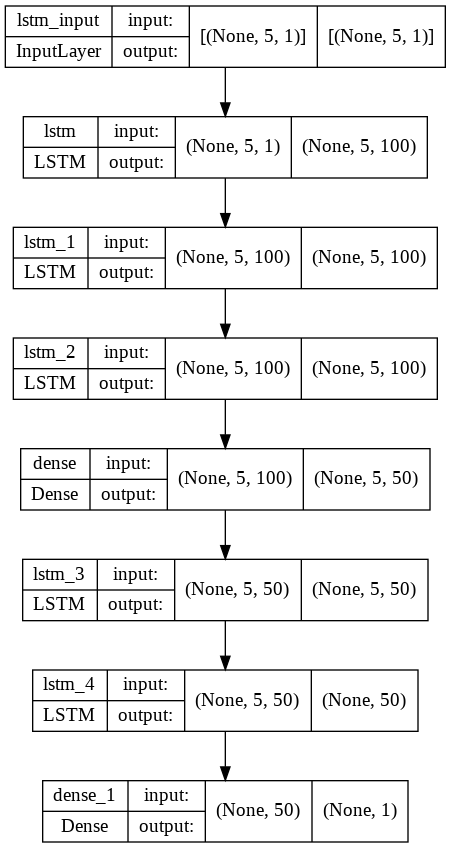

In [12]:
from keras.models import load_model
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
y_pred_train_LSTM = model.predict(np.asarray(X_train).astype('float32'))
Inverse_y_train = y_train.reshape(-1,1)
Inverse_y_train = scaler.inverse_transform(Inverse_y_train)
Inverse_y_pred_train_LSTM = y_pred_train_LSTM.reshape(-1,1)
Inverse_y_pred_train_LSTM = scaler.inverse_transform(Inverse_y_pred_train_LSTM)

y_pred_test_LSTM = model.predict(np.asarray(X_test).astype('float32'))
Inverse_y_test = y_test.reshape(-1,1)
Inverse_y_test = scaler.inverse_transform(Inverse_y_test)
Inverse_y_pred_test_LSTM = y_pred_test_LSTM.reshape(-1,1)
Inverse_y_pred_test_LSTM = scaler.inverse_transform(Inverse_y_pred_test_LSTM)

y_pred_val_LSTM = model.predict(np.asarray(X_val).astype('float32'))
Inverse_y_val = y_val.reshape(-1,1)
Inverse_y_val = scaler.inverse_transform(Inverse_y_val)
Inverse_y_pred_val_LSTM = y_pred_val_LSTM.reshape(-1,1)
Inverse_y_pred_val_LSTM = scaler.inverse_transform(Inverse_y_pred_val_LSTM)

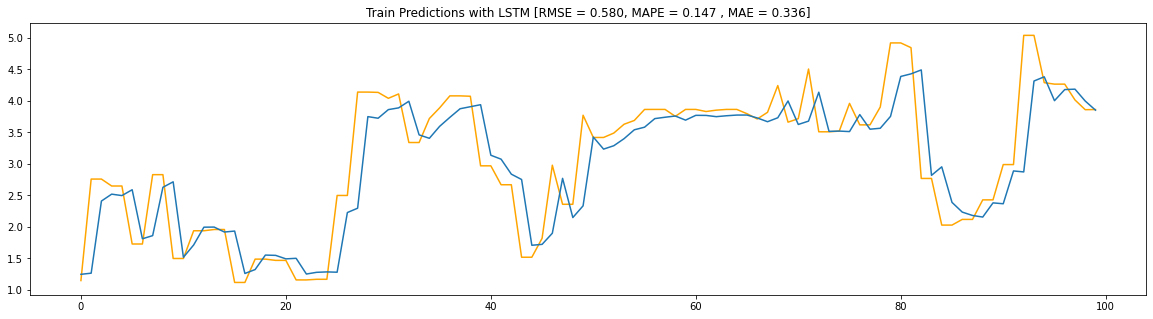

In [14]:
mape, mae, rmse = forecast_accuracy(Inverse_y_pred_train_LSTM, Inverse_y_train)

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(Inverse_y_train[0:100], color='orange')
plt.plot(Inverse_y_pred_train_LSTM[0:100])
plt.title("Train Predictions with LSTM [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

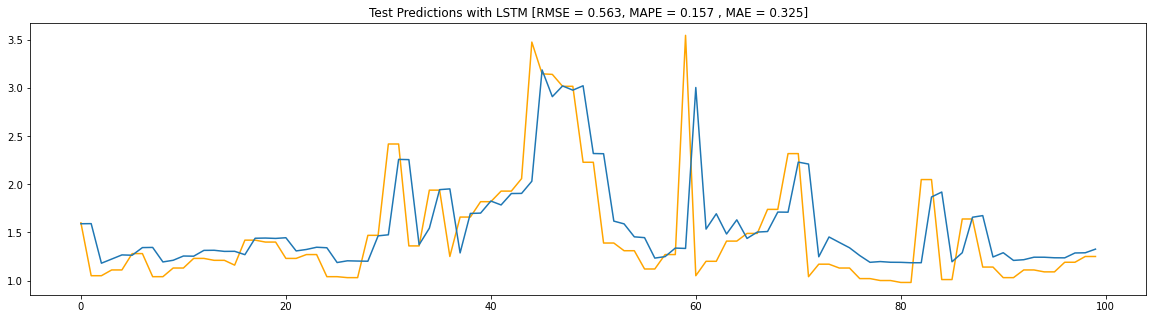

In [15]:
mape, mae, rmse = forecast_accuracy(Inverse_y_pred_test_LSTM, Inverse_y_test)

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(Inverse_y_test[0:100], color='orange')
plt.plot(Inverse_y_pred_test_LSTM[0:100])
plt.title("Test Predictions with LSTM [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

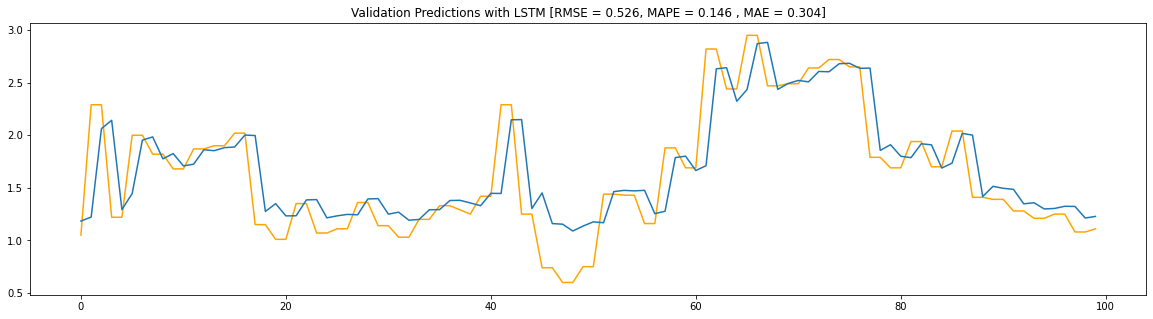

In [16]:
mape, mae, rmse = forecast_accuracy(Inverse_y_pred_val_LSTM, Inverse_y_val)

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(Inverse_y_val[0:100], color='orange')
plt.plot(Inverse_y_pred_val_LSTM[0:100])
plt.title("Validation Predictions with LSTM [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

## View report ✅
https://wandb.ai/malekkamoua/Stacked_lstm_shot_2/reports/Untitled-Report--VmlldzoxOTczNDc1?accessToken=ul18m2tv2ozhqo6w8gk93fi4edfepqzua9uld3p6dvd7ost5e4yavjwl0wu95yo3